In [1]:
import sys 
import pandas as pd
# Import functions
from recommenders.models.tfidf.tfidf_utils import TfidfRecommender


print(f"System version: {sys.version}")

System version: 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]


In [2]:
# Load movies metadata
metadata = pd.read_csv('./data/movies_metadata.csv', low_memory=False)

metadata.head(3)

metadata['overview'] = metadata['overview'].fillna('')

# load credits and keywords
credits = pd.read_csv('./data/credits.csv')
keywords = pd.read_csv('./data/keywords.csv')

# remove rows with bad ids
metadata = metadata.drop([19730, 29503, 35587])

# Convert IDs to int. Required for merging
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata['id'] = metadata['id'].astype('int')

# Merge keywords and credits into your main metadata dataframe
metadata = metadata.merge(credits, on='id')
metadata = metadata.merge(keywords, on='id')

In [3]:
metadata.shape

(46628, 27)

In [4]:
_list = []
for index, row in metadata.iterrows():
    if row['vote_count'] >= 25.0:
        _list.append(row)
        
len(_list)

14046

In [5]:
filter_ = metadata['vote_count'] >= 25.0
metadata = metadata[filter_]
print(metadata.shape)

(14046, 27)


<AxesSubplot:title={'center':'Released?'}>

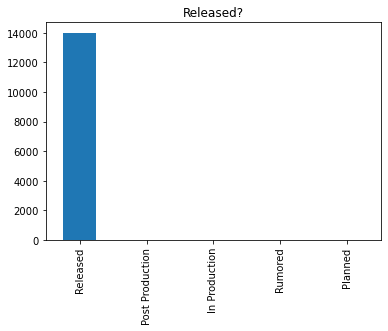

In [6]:
metadata['status'].value_counts().plot(kind='bar', title='Released?')

In [7]:
print("Number of movies we are working with: " + str(len(metadata)))

Number of movies we are working with: 14046


In [8]:
import numpy as np

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        # Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names
    
    # Return empty list in case of missing/malformed data
    return []

In [9]:
from ast import literal_eval

# Parse the stringified feature into their corresponding python objects
features = ["cast", "crew", "keywords", "genres"]
for feature in features:
    metadata[feature] = metadata[feature].apply(literal_eval)

# Define new director, cast, genres, and keywords feature that are in a suitable form
metadata['director'] = metadata['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata[feature] = metadata[feature].apply(get_list)
    
# Print the new featuers of the first 3 films
metadata[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy]","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger]","[Romance, Comedy]"


In [10]:
# Function to convert all string to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(' ', '')) for i in x]
    else:
        # Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(' ', ''))
        else:
            return ''

In [11]:
# Apply clean)data function to your features
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata[feature] = metadata[feature].apply(clean_data)
    
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

# Create new soup feature
metadata['soup'] = metadata.apply(create_soup, axis=1)

metadata[['soup']].head(2)

,soup
0,jealousy toy boy tomhanks timallen donrickles ...
1,boardgame disappearance basedonchildren'sbook ...


In [12]:
metadata.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,NaN,Toy Story,False,7.7,5415.0,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildren'sbook ...


In [13]:
# Define the recommender lol
recommender = TfidfRecommender(id_col='id', tokenization_method='none')


# Assign columns to clean and combine
cols_to_clean = ['soup']
clean_col = 'soup'


df_clean = recommender.clean_dataframe(metadata, cols_to_clean, clean_col)

In [14]:
# df_clean = df_clean.drop('cleaned_text', axis=1)
print(df_clean.columns)

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'director',
       'soup'],
      dtype='object')


In [15]:
df_clean = df_clean[['genres', 'id','overview','title','cast','crew','keywords','director','soup']]

df_clean.head(2)

,genres,id,overview,title,cast,crew,keywords,director,soup
0,"[animation, comedy, family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story,"[tomhanks, timallen, donrickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy]",johnlasseter,jealousy toy boy tomhanks timallen donrickles ...
1,"[adventure, fantasy, family]",8844,When siblings Judy and Peter discover an encha...,Jumanji,"[robinwilliams, jonathanhyde, kirstendunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[boardgame, disappearance, basedonchildren'sbook]",joejohnston,boardgame disappearance basedonchildrensbook r...


In [16]:
# Tokenize text with tokenization_method specified in class instantiation
tf, vectors_tokenized = recommender.tokenize_text(df_clean, text_col=clean_col)

In [17]:
for index, row in df_clean.iterrows():
    print(row['title'])

Toy Story
Jumanji
Grumpier Old Men
Waiting to Exhale
Father of the Bride Part II
Heat
Sabrina
Tom and Huck
Sudden Death
GoldenEye
The American President
Dracula: Dead and Loving It
Balto
Nixon
Cutthroat Island
Casino
Sense and Sensibility
Four Rooms
Ace Ventura: When Nature Calls
Money Train
Get Shorty
Copycat
Assassins
Powder
Leaving Las Vegas
Othello
Now and Then
Persuasion
The City of Lost Children
Dangerous Minds
Twelve Monkeys
Babe
Dead Man Walking
It Takes Two
Clueless
Richard III
Dead Presidents
Restoration
Mortal Kombat
To Die For
How To Make An American Quilt
Se7en
Pocahontas
The Usual Suspects
Mighty Aphrodite
The Big Green
Home for the Holidays
The Postman
The Indian in the Cupboard
Eye for an Eye
Mr. Holland's Opus
Don't Be a Menace to South Central While Drinking Your Juice in the Hood
Bio-Dome
Lawnmower Man 2: Beyond Cyberspace
French Twist
Friday
From Dusk Till Dawn
Fair Game
Kicking and Screaming
Bed of Roses
Screamers
The Crossing Guard
The Juror
Things to Do in Denver

Paradise Lost: The Child Murders at Robin Hood Hills
The Preacher's Wife
Ridicule
The Crucible
101 Dalmatians
Die Hard 2
Star Trek: The Motion Picture
Star Trek VI: The Undiscovered Country
Star Trek V: The Final Frontier
Star Trek II: The Wrath of Khan
Star Trek III: The Search for Spock
Star Trek IV: The Voyage Home
Batman Returns
Young Guns
Young Guns II
Grease
Grease 2
Marked for Death
Under Siege
Jaws
Jaws 2
Jaws 3-D
My Fellow Americans
Mars Attacks!
Citizen Ruth
Jerry Maguire
Raising Arizona
Tin Men
Sneakers
In Love and War
Marvin's Room
Ghosts of Mississippi
Beavis and Butt-Head Do America
La Cérémonie
Scream
The Last of the Mohicans
Michael
Hamlet
Evita
The Portrait of a Lady
Walkabout
Murder at 1600
Fierce Creatures
Turbulence
First Strike
Beverly Hills Ninja
Metro
Dante's Peak
Amos & Andrew
Benny & Joon
McHale's Navy
Kolya
Gridlock'd
Waiting for Guffman
The Beautician and the Beast
SubUrbia
The Pest
Fools Rush In
Absolute Power
Vegas Vacation
Lost Highway
Rosewood
Donnie Bras

Shadow of a Doubt
Saboteur
Mr. & Mrs. Smith
Suspicion
Jamaica Inn
The Lady Vanishes
Young and Innocent
Sabotage
Secret Agent
The Man Who Knew Too Much
Blackmail
The Lodger: A Story of the London Fog
Rounders
Cube
Simon Birch
Swept Away
My Bodyguard
Class
Broadcast News
Working Girl
Married to the Mob
Say Anything...
My Blue Heaven
Hero
Toys
Blame It on Rio
One Crazy Summer
About Last Night...
The Seventh Sign
We're No Angels
Nothing but Trouble
The Butcher's Wife
Mortal Thoughts
A Few Good Men
Indecent Proposal
Permanent Midnight
One True Thing
Rush Hour
Six-String Samurai
Ronin
Urban Legend
Clay Pigeons
Pecker
The Sheltering Sky
If....
Them!
The Thing
The Player
Stardust Memories
Edward Scissorhands
Antz
A Night at the Roxbury
What Dreams May Come
Strangeland
The Producers
History of the World: Part I
My Cousin Vinny
Nashville
Holy Man
The Mighty
2010
Children of a Lesser God
The Elephant Man
Beloved
Bride of Chucky
Practical Magic
Happiness
Apt Pupil
Pleasantville
Soldier
Life Is Bea

The Blue Lagoon
A Fistful of Dollars
Hard Eight
Home Alone 2: Lost in New York
Someone to Watch Over Me
Fight Club
The Story of Us
Fever Pitch
Julien Donkey-Boy
The Straight Story
The Bad Seed
Time Bandits
A Man and a Woman
Fitzcarraldo
All That Jazz
Red Sorghum
Crimes and Misdemeanors
Bats
The Best Man
Bringing Out the Dead
Three to Tango
The Guardian
The Ipcress File
RoboCop
RoboCop 2
Who Framed Roger Rabbit
For Your Eyes Only
Licence to Kill
Live and Let Die
Rawhead Rex
Thunderball
House on Haunted Hill
Music of the Heart
Being John Malkovich
Princess Mononoke
My Best Fiend
Train of Life
The Bachelor
The Bone Collector
The Insider
American Movie
Last Night
Rosetta
They Shoot Horses, Don't They?
Bride of Re-Animator
Coma
Creepshow
Creepshow 2
Re-Animator
Drugstore Cowboy
Falling Down
The Funhouse
The General
Piranha
The Taming of the Shrew
Nighthawks
Yojimbo
Repossessed
The Omega Man
Spaceballs
Robin Hood
Mister Roberts
Quest for Fire
Little Big Man
A Face in the Crowd
Trading Places

Red Heat
Return of the Living Dead Part II
The Return of the Living Dead
The Man from Snowy River
Running on Empty
The Serpent and the Rainbow
Shoot to Kill
Short Circuit 2
Short Circuit
The Vanishing
Tetsuo: The Iron Man
They Live
Torch Song Trilogy
Tucker: The Man and His Dream
Twins
Vice Versa
Watchers
Waxwork
Without a Clue
Young Einstein
Always
American Ninja
American Ninja 2: The Confrontation
American Ninja 3: Blood Hunt
Best of the Best 2
Bill & Ted's Excellent Adventure
Black Rain
Blind Fury
C.H.U.D. II: Bud the Chud
Casualties of War
Chances Are
Cyborg
Dream a Little Dream
The Dream Team
Earth Girls Are Easy
Eddie and the Cruisers
Erik the Viking
Family Business
Fat Man and Little Boy
Gleaming the Cube
Going Overboard
Great Balls of Fire!
Harlem Nights
Her Alibi
How to Get Ahead in Advertising
An Innocent Man
Jacknife
The January Man
Johnny Handsome
K-9
Kickboxer
Last Exit to Brooklyn
Lean On Me
Let It Ride
Leviathan
Little Monsters
Lock Up
Look Who's Talking
Loverboy
Major L

2 Fast 2 Furious
Whale Rider
Nevada Smith
Once a Thief
A Man Called Horse
Big Jake
The Crazies
Le Mans
Rio Lobo
The Swimmer
The White Sheik
Treasure Island
Two Evil Eyes
Bend of the River
Car Wash
Destry Rides Again
The Electric Horseman
Shenandoah
Oscar
The Far Country
The Railway Children
Two Mules for Sister Sara
Winchester '73
Man with a Movie Camera
This Boy’s Life
Barton Fink
Battle of Britain
Belle Époque
The Big Trail
The Comancheros
The Flight of the Phoenix
Heaven Knows, Mr. Allison
The Hot Rock
The Long, Hot Summer
Music Box
North to Alaska
Sink the Bismarck!
The Blue Max
The Trial
The Unforgiven
The Undefeated
Good Burger
Cahill U.S. Marshal
Chisum
Shattered
The Life and Times of Judge Roy Bean
Thoroughly Modern Millie
Dumb and Dumberer: When Harry Met Lloyd
Hollywood Homicide
Rugrats Go Wild
Jet Lag
Alex & Emma
Experiment in Terror
Is Paris Burning?
The Satanic Rites of Dracula
28 Days Later
Charlie's Angels: Full Throttle
Fulltime Killer
Ali: Fear Eats the Soul
You Only L

Flesh + Blood
King Solomon's Mines
Raw Deal
Goodbye, Mr. Chips
Fire Birds
Against the Ropes
Confessions of a Teenage Drama Queen
EuroTrip
The Passion of the Christ
Club Dread
Dirty Dancing: Havana Nights
Twisted
Good bye, Lenin!
Hidalgo
Starsky & Hutch
The Reckoning
Persona
The Passion of Anna
Le Corbeau
The Front
Pickup on South Street
The Damned
Richard III
Just One of the Guys
The Chase
Agent Cody Banks 2: Destination London
The Girl Next Door
Secret Window
Spartan
Wilbur Wants to Kill Himself
Mad Dog and Glory
Dawn of the Dead
Eternal Sunshine of the Spotless Mind
Taking Lives
Intermission
Noi the Albino
Jersey Girl
The Ladykillers
Never Die Alone
Scooby-Doo 2: Monsters Unleashed
Dogville
Ned Kelly
Hellboy
Home on the Range
The Prince & Me
Walking Tall
The United States of Leland
Johnson Family Vacation
The Alamo
Ella Enchanted
The Whole Ten Yards
I'm Not Scared
Shade
The Ten Commandments
Dawn of the Dead
One Million Years B.C.
Those Magnificent Men in Their Flying Machines or How 

Shall We Dance?
Team America: World Police
Eulogy
Tess
I Wanna Hold Your Hand
The Fearless Vampire Killers
The Five Obstructions
It's Alive
Friday Night Lights
The Final Cut
Riding the Bullet
Surviving Christmas
The Grudge
Alfie
Sideways
The Machinist
Vera Drake
Undertow
Enduring Love
Saw
Ray
Birth
The Incredibles
It's All About Love
The Polar Express
Kinsey
Seed of Chucky
After the Sunset
Bridget Jones: The Edge of Reason
Finding Neverland
Veer-Zaara
National Treasure
Bad Education
The SpongeBob SquarePants Movie
Alexander
Christmas with the Kranks
Closer
I Am David
House of Flying Daggers
Ocean's Twelve
Blade: Trinity
Cinderfella
D.A.R.Y.L.
Fire in the Sky
Love Me If You Dare
Dr. Jekyll and Mr. Hyde
The Golem: How He Came Into the World
The Phantom Carriage
Destiny
Häxan
Sherlock, Jr.
Greed
The Phantom of the Opera
The Jazz Singer
October (Ten Days that Shook the World)
Pandora's Box
The Cameraman
The Crowd
The Man Who Laughs
Steamboat Bill, Jr.
Un chien andalou
Little Caesar
L'Âge d

The Brown Bunny
Ju-on: The Curse
Ju-on: The Curse 2
11:14
Tremors 4: The Legend Begins
Bring It On Again
Crimson Rivers II: Angels of the Apocalypse
Evil
Sniper 2
Battle Royale II: Requiem
In Hell
Lemony Snicket's A Series of Unfortunate Events
Naked Weapon
The Green Butchers
A Very Long Engagement
Last Life in the Universe
Head-On
Ghost in the Shell 2: Innocence
Kal Ho Naa Ho
The Cat Returns
Unstoppable
Take My Eyes
The Twilight Samurai
The Twins Effect
Facing Windows
Ginger Snaps 2: Unleashed
Salem's Lot
Dark Woods
Foolproof
Belly of the Beast
When the Last Sword Is Drawn
Ju-on: The Grudge
Oldboy
Ginger Snaps Back: The Beginning
One Missed Call
The Jacket
Millions
Starship Troopers 2: Hero of the Federation
The Man Who Copied
Ju-on: The Grudge 2
Interstella 5555: The 5tory of the 5ecret 5tar 5ystem
Ong-Bak: The Thai Warrior
Infernal Affairs II
The Sea Inside
Spanglish
The Chorus
Saints and Soldiers
The Weeping Camel
The Interpreter
Open Water
Infernal Affairs III
The Memory Of A Kill

Tarzan the Ape Man
Tarzan and His Mate
Empire of the Wolves
Manderlay
Damnation Alley
The Adventures of Prince Achmed
Revolver
Jarhead
Chicken Little
Romance & Cigarettes
Dead Man's Shoes
Joyeux Noël
The Brides of Dracula
The House That Dripped Blood
The Gorgon
Night of the Lepus
The Match Factory Girl
Get Rich or Die Tryin'
Just Friends
Syriana
La Vie de Bohème
Derailed
Creep
Pride & Prejudice
Edison
Wolf Creek
The Descent
Harry Potter and the Goblet of Fire
Walk the Line
Rent
Zathura: A Space Adventure
CRAZY
Lonesome Jim
Bee Season
Breakfast on Pluto
The Ice Harvest
Yours, Mine & Ours
The Libertine
The Wild Geese
Hondo
The Bird with the Crystal Plumage
A Good Woman
The Evil of Frankenstein
The Driver
Match Point
The Deep
Paradise Now
The Chronicles of Narnia: The Lion, the Witch and the Wardrobe
King Kong
Memoirs of a Geisha
The Family Stone
The Promise
Kiss of Death
Havoc
Samurai Rebellion
The Matador
7 Seconds
Mozart and the Whale
A Scene at the Sea
Don't Look Now: We're Being Shot

Stomp the Yard
Miss Potter
Arthur and the Invisibles
Loving Annabelle
American Pie Presents: The Naked Mile
The Young Girls of Rochefort
Alice in the Cities
Old Joy
The Banquet
Venus
The Return of Don Camillo
Don Camillo
Primeval
Alpha Dog
The Hitcher
The Dead Girl
House Of 9
After the Wedding
Time
Dinner for One
Linda Linda Linda
Daisies
Bridge to Terabithia
Killer of Sheep
The Blood of a Poet
House
Waitress
The Secret
Neverwas
R-Point
Catch and Release
Smokin' Aces
Blood and Chocolate
Epic Movie
The Messengers
Because I Said So
Hannibal Rising
Norbit
The Boss of It All
Cocaine Cowboys
Lonely Hearts
Ratatouille
Five Fingers
Izo
Lola
Paris, je t'aime
The Astronaut Farmer
Wake Up, Ron Burgundy: The Lost Movie
SPL: Kill Zone
It's a Boy Girl Thing
Days of Glory
The Odyssey
Unknown
Magical Mystery Tour
Trailer Park Boys: The Movie
Ghost Rider
Breach
Music and Lyrics
The Number 23
Reno 911!: Miami
Black Snake Moan
Gray Matters
My Father and My Son
Factory Girl
Human Trafficking
Kidulthood
S

17 Again
Double Trouble
Inglourious Basterds
State of Play
Strike
The Damned United
Crank: High Voltage
Moon
Mammoth
The Young Victoria
The Informers
X-Men Origins: Wolverine
The Girlfriend Experience
Sin Nombre
Star Trek
Lymelife
The Great Buck Howard
Cherry Blossoms
Flatfoot in Egypt
XIII
Red Cliff Part II
The Girl from Monaco
Wild Things: Diamonds in the Rough
S. Darko
Earth
Stanley Kubrick: A Life in Pictures
Crossing Over
Angels & Demons
Balls Out: The Gary Houseman Story
Powder Blue
Fanboys
Live!
Incendiary
Love Songs
Management
Terminator Salvation
Night at the Museum: Battle of the Smithsonian
Were The World Mine
Lesbian Vampire Killers
The Brothers Bloom
Vincere
Paisan
Jeanne Dielman, 23, Quai du Commerce 1080 Bruxelles
I Do
Caliber 9
Catacombs
The Soloist
The Last House on the Left
Neon Genesis Evangelion: Death and Rebirth
Drag Me to Hell
Up
Fullmetal Alchemist the Movie: Conqueror of Shamballa
Easy Virtue
Dance Flick
Summer Hours
OSS 117: Lost in Rio
Personal Effects
Fired 

The Bone Man
I Hate Valentine's Day
Air Doll
Micmacs
Clash of the Titans
Growth
The Cremator
Defendor
Glorious 39
Kick-Ass
Chalte Chalte
Five Minutes of Heaven
Date Night
The Pit and the Pendulum
Kronk's New Groove
After.Life
Camille
Mortadelo & Filemon: The Big Adventure
Angel
The Final
Peacock
The Runaways
Carne
It! The Terror from Beyond Space
Daisy
Razorback
The Education of Charlie Banks
Reclaim Your Brain
Death at a Funeral
Valhalla Rising
Diary of a Wimpy Kid
The Union: The Business Behind Getting High
I Am Love
Ballet Shoes
Disgrace
American Virgin
Dogtooth
City of Life and Death
Scarecrows
The Beast
The Losers
Panda! Go Panda!
The Last Song
Cyrus
The Human Centipede (First Sequence)
Exit Through the Gift Shop
Solomon Kane
Iron Man 2
Lebanon
Marmaduke
MacGruber
Ca$h
Lucky Luke and the Daltons
Three Men and a Cradle
The Sky Crawlers
Games of Love and Chance
Dead of Night
Vengeance
Virtuality
Cargo
A Nightmare on Elm Street
Four Lions
Diary of a Nymphomaniac
Gunless
Furry Vengean

The Raven
The Big Bang
Mirror Mirror
Battleship
Our Day Will Come
Goodbye First Love
The Best Exotic Marigold Hotel
King of Devil's Island
Twelve
Sharpay's Fabulous Adventure
Bullhead
Bully
Hysteria
Dante's Inferno: An Animated Epic
The Five-Year Engagement
Elsewhere
The Devil's Rock
Think Like a Man
The Lucky One
Safe
Jumping the Broom
Feast III: The Happy Finish
Red Dog
Dark Shadows
The Scorpion King: Rise of a Warrior
96 Minutes
Columbus Circle
The Decoy Bride
Beyond the Black Rainbow
The Clown
Rocket Singh: Salesman of the Year
Vicky Donor
Three Steps Above Heaven
The Dictator
The Heir Apparent: Largo Winch
Gifted Hands: The Ben Carson Story
Men in Black 3
Snow White and the Huntsman
Sound of My Voice
Night of the Demons
EVA
Chernobyl Diaries
Chicken with Plums
The Pirates! In an Adventure with Scientists!
A Better Life
Hemingway & Gellhorn
Hick
Prometheus
The Pact
Letters to God
Bernie
Desi Boyz
Inhale
Take This Waltz
Sound of Noise
Wanderlust
Moonrise Kingdom
There Be Dragons
Tex

Keep the Lights On
Girl Model
Omar Killed Me
Die
Sunny
My Way
Le Chef
Choose
Movie 43
Night of the Demons 2
Death Race: Inferno
The Pervert's Guide to Ideology
Parker
A Simple Life
Sightseers
Hansel & Gretel: Witch Hunters
After Porn Ends
Angelique
Stonehenge Apocalypse
Starlet
Godzilla vs. Gigan
Why Stop Now?
The Big Picture
The East
Blancanieves
Tabu
Upside Down
The Liability
Angst
The Baytown Outlaws
Stand Up Guys
Le grand soir
Udaan
Hawking
No
Now Is Good
The Haunting in Connecticut 2: Ghosts of Georgia
Resident Evil: Degeneration
Side Effects
Identity Thief
The ABCs of Death
Resident Evil: Damnation
The Bang Bang Club
The Gatekeepers
A Glimpse Inside the Mind of Charles Swan III
Lore
The Devil's Tomb
Game of Death
Chinese Zodiac
Song for Marion
Beautiful Creatures
A Good Day to Die Hard
21 & Over
Tale of Tales
War Witch
Safe Haven
Elles
Frozen Planet
The Act of Killing
Universal Soldier: Day of Reckoning
Room 237
Escape from Planet Earth
Confessions of a Brazilian Call Girl
Before

The Visitor
The Stag
Tables Turned on the Gardener
Hellion
The Trip to Italy
Earth to Echo
Largo Winch II
Maidentrip
Step Up All In
Video Games: The Movie
Life After Beth
Felony
The Rover
The Italian
Get on Up
1
The Suspect
Magic in the Moonlight
And While We Were Here
Winter Sleep
In Order of Disappearance
Housebound
The Hundred-Foot Journey
Batman: Assault on Arkham
R100
The Den
Zero Motivation
Jupiter Ascending
Teenage Mutant Ninja Turtles
I'll Follow You Down
Rob the Mob
The Giver
The Pretty One
Revenge of the Green Dragons
Let's Be Cops
Antboy
Appleseed Alpha
Carry On... Up the Khyber
Switch
Bad Johnson
The Inbetweeners 2
The Sacrament
Make Your Move
Sin City: A Dame to Kill For
If I Stay
The Canal
Night Moves
Proxy
Are You Here
Welcome to New York
Two Days, One Night
Lights Out
Coherence
Cantinflas
The Pyramid
Exists
Life of Crime
As Above, So Below
The One I Love
El niño
Antisocial
The Guest
Leprechaun: Origins
To Be Takei
Angry Video Game Nerd: The Movie
Before I Go to Sleep
Pr

The Duke of Burgundy
Red Army
Shortcut to Happiness
Java Heat
Peeples
Save the Last Dance 2
The Skeptic
When in Rome
F
The Single Moms Club
Nothing Left to Fear
Hansel & Gretel
The Power of Few
Private Valentine: Blonde & Dangerous
Gun
The Reunion
I Am Ali
Supermensch: The Legend of Shep Gordon
It Follows
The Anomaly
Touchback
Unit 7
Wishmaster 3: Beyond the Gates of Hell
Thunderstruck
The Town that Dreaded Sundown
White Elephant
Leprechaun: Back 2 tha Hood
No Man's Land: The Rise of Reeker
The Shortcut
Sometimes They Come Back... Again
U.F.O.
Little Lord Fauntleroy
The Six Wives of Henry Lefay
Swinging with the Finkels
Someone's Gaze
Goodbye to Language
The Perfect World of Kai
The Berlin File
The Attorney
All Things Fall Apart
Altitude
Get a Horse!
Happy New Year
Jack the Giant Killer
Picture This
Mardi Gras: Spring Break
Wishmaster 4: The Prophecy Fulfilled
Lizzie Borden Took An Ax
Switching Goals
The End
The White Buffalo
Grave Halloween
At the Devil's Door
Reaching for the Moon
Th

P.R.O.F.S
The Ages of Love
Last Knights
Kiss Me Again
The Jinx: The Life and Deaths of Robert Durst
Batman vs. Robin
Nice and Easy
Woman in Gold
Samba
Cut Bank
Seven Dwarfs
Slaughter High
The Road Within
Lemonade Mouth
Tomorrowland
The Forger
Long Live Freedom
Far from Men
Good Kill
Alex of Venice
Hungry Hearts
Faults
Cub
The Barber
Good Deeds
Black Souls
The Harvest
Paul Blart: Mall Cop 2
El Infierno
Adult Beginners
Parts Per Billion
The Prince & Me: A Royal Honeymoon
Breathe
I Am Soldier
Holiday in the Sun
Spiders
Survivor
NH10
Book of Blood
Outcast
The Admiral: Roaring Currents
Tazza: The Hidden Card
The Marine 4: Moving Target
The Longest Ride
Beyond the Reach
Atari: Game Over
Lage Raho Munna Bhai
Monkey Kingdom
Sword of Vengeance
Antarctica: A Year on Ice
The Age of Adaline
The Liberator
Lovesick
Danny Collins
Halo: Nightfall
A Girl Like Her
Grandma
Mea Culpa
Comedy Central Roast of Justin Bieber
The Even Stevens Movie
A Royal Night Out
Barbecue
Dior and I
The Walking Deceased
Kit

Cado dalle nubi
Scialla!
The Gallows
In My Dreams
Tokyo Tribe
Embrace of the Vampire
Spiders
Basilicata coast to coast
Feast
Crawl or Die
Shank
Joe Dirt 2: Beautiful Loser
The Death of "Superman Lives": What Happened?
The Dream Team
Ticks
Dragon Ball: Episode of Bardock
Werewolf: The Beast Among Us
My Golden Days
Dark Places
I'll Always Know What You Did Last Summer
In Another Country
Boulevard
Mustang
Microbe and Gasoline
Afro Samurai
Bajrangi Bhaijaan
Un fidanzato per mia moglie
Tanu Weds Manu Returns
Intruder
Pressure
The Revenant
Il cosmo sul comò
Irrational Man
Tale of Tales
Cleveland Abduction
Lissi and the Wild Emperor
Exte: Hair Extensions
One Missed Call 2
The Boy in the Plastic Bubble
Cartel Land
Always
Baahubali: The Beginning
Pokémon Ranger and the Temple of the Sea
Learning to Drive
The True Cost
Ooops! Noah is Gone...
Southpaw
Sicario
Goodnight Mommy
One Wild Moment
War Pigs
X+Y
Dark Was the Night
Before We Go
Best of Enemies
Lavalantula
Smosh: The Movie
Marina
Bad Turn W

Sanjay's Super Team
The Wave
Some Kind Of Hate
The Hollow
Quantum Apocalypse
10.0 Earthquake
Mega Shark vs. Mecha Shark
Chi-Raq
Babysitting 2
Les Dissociés
Monkey King: Hero Is Back
Truth
Another Gay Sequel: Gays Gone Wild!
Our Times
The Big Short
The Ridiculous 6
John Mulaney: The Comeback Kid
Saw
American Hero
Night Owls
Architecture 101
The Girl in the Book
Mojave
Tumbledown
Wizards of Waverly Place: The Movie
Inbred
Ghost in the Shell: The New Movie
Extraction
World of Tomorrow
Zoolander 2
The Legend of Barney Thomson
The Lion Guard: Return of the Roar
Vampire Circus
How to Be Single
Wir sind die Neuen
Anguish
Blue Exorcist: The Movie
The Propaganda Game
He Never Died
Troublemakers
The Perfect Weapon
Another World
Parasyte: Part 1
Parasyte: Part 2
Fifty Shades of Black
The Band of Honest Men
Nocturnal Animals
Daddy's Home
Sisters
A Christmas Detour
Night Of The Living Deb
Kung Fu Panda 3
Kung Fu Panda 3
Whatcha Wearin'?
Whatcha Wearin'?
Spellbound
Spellbound
The Sweet Escape
The Sw

Gimme Danger
Capsule
Man vs. Snake
Go Figure
The Cheetah Girls 2
Cloud 9
Teen Beach 2
The Cheetah Girls
Mansfield Park
The Wizards Return: Alex vs. Alex
H2O Just Add Water - The Movie
Princess of Thieves
Harriet the Spy: Blog Wars
Honey 2
Colossal
A Cinderella Story: If the Shoe Fits
Blue Jay
Voyage of Time: Life's Journey
La La Land
13th
Validation
Air Mater
The Siege of Jadotville
Being 17
The Present
The Salesman
Barbie in Rock 'N Royals
Barbie: Spy Squad
Allied
The Monster
Phantasm: Ravager
Baked in Brooklyn
Batman: Return of the Caped Crusaders
Brimstone
Inferno
Keeping Up with the Joneses
Ouija: Origin of Evil
Mascots
Crisis in Six Scenes
Patient Seven
Trolls
Max Steel
Struggle for Life
Operator
Supersonic
21 Nights with Pattie
The Swap
My Bakery in Brooklyn
Always Shine
Denial
The Rocky Horror Picture Show: Let's Do the Time Warp Again
Jack Reacher: Never Go Back
Frank & Lola
In a Valley of Violence
Borrowed Time
The Red Pill
American Pastoral
Fear, Inc.
Into the Inferno
Mr. Chu

Program
Ghost Recon: Alpha
The Day of the Triffids
Blame!
Kill Switch
The Bad Batch
War for the Planet of the Apes
Kidnap
Underworld: Endless War
War Machine
2 Alone in Paris
La Tour Montparnasse Infernale
Mohamed Dubois
Halal Police d'Etat
Hangar 10
Beur sur la ville
Red Sun
Wakefield
Red Nose Day Actually
Whitney: Can I Be Me
Valerian and the City of a Thousand Planets
The Gracefield Incident
Sharpe's Rifles
The Night Before the Exams
The Yellow Eyes of Crocodiles
The Magic Roundabout
Rock'n Roll
Black Butterfly
Nemesis
Superfantozzi
The Second Tragic Fantozzi
2012 Doomsday
Combustion
Fugitives
The Voyeur
The Chronicles of Riddick: Dark Fury
Manitou's Shoe
Appleseed: Ex Machina
After Love
The Dancer
We Are Family
Brain on Fire
Fanaa
Lucid Dream
Drone
Dragonheart: Battle for the Heartfire
Tourist Trap
Stasis
Gulliver's Travels
Shimmer Lake
Center of My World
What Happened to Monday
Atomic Blonde
Duck Dodgers in the 24½th Century
The Exception
Goon: Last of the Enforcers
Black Mirror: 

In [18]:
# Needed to find specific movies to compile a list for looking for recommendations
for index, row in df_clean.iterrows():
    if row['director'] == 'jimjarmusch':
        print(row['title'] + '\t\t\t' + str(row['id']))

Dead Man			922
Down by Law			1554
Night on Earth			339
Ghost Dog: The Way of the Samurai			4816
Mystery Train			11305
Stranger Than Paradise			469
Permanent Vacation			37997
Coffee and Cigarettes			883
Broken Flowers			308
The Limits of Control			8284
Only Lovers Left Alive			152603
Paterson			370755
Gimme Danger			392820


In [71]:
# idk how to spell some directors names
for index, row in metadata.iterrows():
    if row['title'] == 'Apocalypto':
        print(row['id'])

1579


In [20]:
fav_movies = ['The Departed', 'Brazil', 'The Game', 'Rear Window', 'Bottle Rocket', 'Eraserhead', 'Fargo', 'Requiem for a Dream', 'Crimes and Misdemeanors', 'Night on Earth']
for index, row in df_clean.iterrows():
    if row['title'] in fav_movies:
        print(f"{row['title']} id is {row['id']}")

Bottle Rocket id is 13685
Fargo id is 275
Rear Window id is 567
Brazil id is 68
Night on Earth id is 339
The Game id is 2649
Crimes and Misdemeanors id is 11562
Eraserhead id is 985
Requiem for a Dream id is 641
The Departed id is 1422


In [21]:
# Fit the TF-IDF vectorizer
recommender.fit(tf, vectors_tokenized)

# Recommendations
top_k_recommendations = recommender.recommend_top_k_items(df_clean, k=5)

In [22]:
# Preview the recommender recommendations
top_k_recommendations

,id,rec_rank,rec_score,rec_id
0,862,1,0.279761,863
1,862,2,0.171057,13927
2,862,3,0.171057,13926
3,862,4,0.156793,213121
4,862,5,0.155101,130925
...,...,...,...,...
68985,30840,1,0.144870,362136
68986,30840,2,0.144446,37737
68987,30840,3,0.131973,16535
68988,30840,4,0.123523,7515


In [23]:
type(top_k_recommendations)

pandas.core.frame.DataFrame

In [24]:
# Optionally view full recommendations list
full_rec_list = recommender.recommendations


In [25]:
# Check out the number of recommended movies for one movie
print('Number of recommended articles for ' + '21786' + ': ' + str(len(full_rec_list[13685])))

Number of recommended articles for 21786: 14045


In [26]:
# Optionally view tokens
tokens = recommender.get_tokens()

# Preview 10 tokens
print(list(tokens.keys())[:10])

['jealousy', 'toy', 'boy', 'tomhanks', 'timallen', 'donrickles', 'johnlasseter', 'animation', 'comedy', 'family']


In [27]:
# Preview the first 10 stop words alphabetically
stop_words = list(recommender.get_stop_words())
stop_words.sort()
print(stop_words[:10])

['a', 'about', 'above', 'across', 'after', 'afterwards', 'again', 'against', 'all', 'almost']


In [28]:
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director']
# Example recommendations for the movie 'To Die For'
recommender.get_top_k_recommendations(metadata, 577, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.089772,"[fantasy, drama, comedy]","In Manhattan, the aspirant writer Jabez Stone ...",Shortcut to Happiness,"[anthonyhopkins, alecbaldwin, jenniferlovehewitt]","[{'credit_id': '52fe45449251416c9102c7ed', 'de...",[],alecbaldwin
1,2,0.083071,"[fantasy, drama, comedy]",Roger is a foster child whose irresponsible fa...,Angels in the Outfield,"[dannyglover, brendafricker, josephgordon-levitt]","[{'credit_id': '52fe44aac3a368484e02fd0f', 'de...",[baseball],williamdear
2,3,0.082862,"[fantasy, drama, comedy]",A businessman is reunited with the four lost s...,Heart and Souls,"[robertdowneyjr., charlesgrodin, kyrasedgwick]","[{'credit_id': '52fe44c79251416c75040a5f', 'de...",[afterlife],ronunderwood
3,4,0.074910,"[fantasy, drama, comedy]",Henry Van Cleve presents himself at the gates ...,Heaven Can Wait,"[genetierney, donameche, charlescoburn]","[{'credit_id': '52fe47959251416c7509ea95', 'de...","[hell, devil]",ernstlubitsch
4,5,0.073730,"[fantasy, drama, comedy]","A couple of angels, O'Reilly and Jackson, are ...",A Life Less Ordinary,"[ewanmcgregor, camerondiaz, hollyhunter]","[{'credit_id': '52fe4490c3a36847f809d499', 'de...","[angel, sex, robbery]",dannyboyle


In [29]:
movies_of_interest = ['The Departed', 'Brazil', 'The Game', 'Rear Window', 'Bottle Rocket', 'Eraserhead', 'Fargo', 'Requiem for a Dream', 'Crimes and Misdemeanors', 'Night on Earth']
df_test = pd.DataFrame(columns=metadata.columns)

row_index = [index for index, row in metadata.iterrows() if row['title'] in movies_of_interest]

len(row_index)

10

In [30]:
for i in range(len(row_index)):
    df_test.loc[i] = metadata.loc[row_index[i]] 

In [31]:
df_test

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director,soup
0,False,NaN,7000000,"[comedy, crime, drama]",NaN,13685,tt0115734,en,Bottle Rocket,Upon his release from a mental hospital follow...,...,"They're not really criminals, but everyone's g...",Bottle Rocket,False,6.8,285.0,"[lukewilson, owenwilson, lumicavazos]","[{'credit_id': '52fe458b9251416c7505a35b', 'de...","[brotherbrotherrelationship, robbery, burglar]",wesanderson,brotherbrotherrelationship robbery burglar luk...
1,False,NaN,7000000,"[crime, drama, thriller]",http://www.themoviefargo.com/,275,tt0116282,en,Fargo,"Jerry, a small-town Minnesota car salesman is ...",...,A lot can happen in the middle of nowhere.,Fargo,False,7.7,2080.0,"[williamh.macy, francesmcdormand, stevebuscemi]","[{'credit_id': '52fe4231c3a36847f800af4d', 'de...","[cheating, ransom, salesclerk]",joelcoen,cheating ransom salesclerk williamh.macy franc...
2,False,NaN,1000000,"[drama, mystery, thriller]",NaN,567,tt0047396,en,Rear Window,"Professional photographer L.B. ""Jeff"" Jeffries...",...,It only takes one witness to spoil the perfect...,Rear Window,False,8.2,1531.0,"[jamesstewart, gracekelly, wendellcorey]","[{'credit_id': '52fe4253c3a36847f80157fd', 'de...","[nurse, photographer, suspicionofmurder]",alfredhitchcock,nurse photographer suspicionofmurder jamesstew...
3,False,NaN,15000000,"[comedy, sciencefiction]",NaN,68,tt0088846,en,Brazil,Low-level bureaucrat Sam Lowry escapes the mon...,...,It's only a state of mind.,Brazil,False,7.6,877.0,"[jonathanpryce, robertdeniro, katherinehelmond]","[{'credit_id': '52fe4213c3a36847f8001e6d', 'de...","[bureaucracy, policestate, terror]",terrygilliam,bureaucracy policestate terror jonathanpryce r...
4,False,NaN,3500000,"[comedy, drama]",NaN,339,tt0102536,en,Night on Earth,An anthology of 5 different cab drivers in 5 A...,...,Five Taxis. Five Cities. One Night.,Night on Earth,False,7.5,165.0,"[winonaryder, genarowlands, lisannefalk]","[{'credit_id': '52fe423ac3a36847f800daab', 'de...","[paris, newyork, taxi]",jimjarmusch,paris newyork taxi winonaryder genarowlands li...
5,False,NaN,50000000,"[drama, thriller, mystery]",NaN,2649,tt0119174,en,The Game,"In honor of his birthday, San Francisco banker...",...,What do you get for the man who has everything?,The Game,False,7.5,1556.0,"[michaeldouglas, seanpenn, deborahkaraunger]","[{'credit_id': '52fe4362c3a36847f80506b7', 'de...","[brotherbrotherrelationship, birthday, dangero...",davidfincher,brotherbrotherrelationship birthday dangerofli...
6,False,NaN,19000000,"[comedy, drama]",NaN,11562,tt0097123,en,Crimes and Misdemeanors,An ophthalmologist's mistress threatens to rev...,...,A film about humanity.,Crimes and Misdemeanors,False,7.4,201.0,"[woodyallen, martinlandau, anjelicahuston]","[{'credit_id': '52fe445a9251416c75031c55', 'de...","[newyork, adultery, assassin]",woodyallen,newyork adultery assassin woodyallen martinlan...
7,False,NaN,10000,"[drama, fantasy, horror]",NaN,985,tt0074486,en,Eraserhead,Henry Spencer tries to survive his industrial ...,...,Where your nightmares end...,Eraserhead,False,7.5,500.0,"[jacknance, charlottestewart, allenjoseph]","[{'credit_id': '52fe4296c3a36847f802a5dd', 'de...","[baby, mutant, claustrophobia]",davidlynch,baby mutant claustrophobia jacknance charlotte...
8,False,NaN,4500000,"[crime, drama]",http://www.requiemforadream.com/,641,tt0180093,en,Requiem for a Dream,The hopes and dreams of four ambitious people ...,...,NaN,Requiem for a Dream,False,7.9,2525.0,"[ellenburstyn, jaredleto, jenniferconnelly]","[{'credit_id': '52fe4263c3a36847f801a72b', 'de...","[drugaddiction, junkie, heroin]",darrenaronofsky,drugaddiction junkie heroin ellenburstyn jared...
9,False,NaN,90000000,"[drama, thriller, crime]",http://thedeparted.warnerbros.com/,1422,tt0407887,en,The Departed,"To take down South Boston's Irish Mafia, the p...",...,Lies. Betrayal. Sacrifice. How

In [31]:
df_test = df_test[['genres', 'id','overview','title','cast','crew','keywords','director','soup']]
df_test

,genres,id,overview,title,cast,crew,keywords,director,soup
0,"[comedy, crime, drama]",13685,Upon his release from a mental hospital follow...,Bottle Rocket,"[lukewilson, owenwilson, lumicavazos]","[{'credit_id': '52fe458b9251416c7505a35b', 'de...","[brotherbrotherrelationship, robbery, burglar]",wesanderson,brotherbrotherrelationship robbery burglar luk...
1,"[crime, drama, thriller]",275,"Jerry, a small-town Minnesota car salesman is ...",Fargo,"[williamh.macy, francesmcdormand, stevebuscemi]","[{'credit_id': '52fe4231c3a36847f800af4d', 'de...","[cheating, ransom, salesclerk]",joelcoen,cheating ransom salesclerk williamh.macy franc...
2,"[drama, mystery, thriller]",567,"Professional photographer L.B. ""Jeff"" Jeffries...",Rear Window,"[jamesstewart, gracekelly, wendellcorey]","[{'credit_id': '52fe4253c3a36847f80157fd', 'de...","[nurse, photographer, suspicionofmurder]",alfredhitchcock,nurse photographer suspicionofmurder jamesstew...
3,"[comedy, sciencefiction]",68,Low-level bureaucrat Sam Lowry escapes the mon...,Brazil,"[jonathanpryce, robertdeniro, katherinehelmond]","[{'credit_id': '52fe4213c3a36847f8001e6d', 'de...","[bureaucracy, policestate, terror]",terrygilliam,bureaucracy policestate terror jonathanpryce r...
4,"[comedy, drama]",339,An anthology of 5 different cab drivers in 5 A...,Night on Earth,"[winonaryder, genarowlands, lisannefalk]","[{'credit_id': '52fe423ac3a36847f800daab', 'de...","[paris, newyork, taxi]",jimjarmusch,paris newyork taxi winonaryder genarowlands li...
5,"[drama, thriller, mystery]",2649,"In honor of his birthday, San Francisco banker...",The Game,"[michaeldouglas, seanpenn, deborahkaraunger]","[{'credit_id': '52fe4362c3a36847f80506b7', 'de...","[brotherbrotherrelationship, birthday, dangero...",davidfincher,brotherbrotherrelationship birthday dangerofli...
6,"[comedy, drama]",11562,An ophthalmologist's mistress threatens to rev...,Crimes and Misdemeanors,"[woodyallen, martinlandau, anjelicahuston]","[{'credit_id': '52fe445a9251416c75031c55', 'de...","[newyork, adultery, assassin]",woodyallen,newyork adultery assassin woodyallen martinlan...
7,"[drama, fantasy, horror]",985,Henry Spencer tries to survive his industrial ...,Eraserhead,"[jacknance, charlottestewart, allenjoseph]","[{'credit_id': '52fe4296c3a36847f802a5dd', 'de...","[baby, mutant, claustrophobia]",davidlynch,baby mutant claustrophobia jacknance charlotte...
8,"[crime, drama]",641,The hopes and dreams of four ambitious people ...,Requiem for a Dream,"[ellenburstyn, jaredleto, jenniferconnelly]","[{'credit_id': '52fe4263c3a36847f801a72b', 'de...","[drugaddiction, junkie, heroin]",darrenaronofsky,drugaddiction junkie heroin ellenburstyn jared...
9,"[drama, thriller, crime]",1422,"To take down South Boston's Irish Mafia, the p...",The Departed,"[leonardodicaprio, mattdamon, jacknicholson]","[{'credit_id': '52fe42f5c3a36847f802fed5', 'de...","[undercover, boston, police]",martinscorsese,undercover boston police leonardodicaprio matt...


In [47]:
# Ten Movies I Like
# The Departed: 1422
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 1422, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.250203,[drama],This short film is a metaphor for the Vietnam ...,The Big Shave,[],"[{'credit_id': '52fe4772c3a36847f8135ffd', 'de...",[],martinscorsese
1,2,0.156085,"[drama, thriller, mystery]",World War II soldier-turned-U.S. Marshal Teddy...,Shutter Island,"[leonardodicaprio, markruffalo, benkingsley]","[{'credit_id': '5370922d0e0a2647d4014298', 'de...","[basedonnovel, island, hurricane]",martinscorsese
2,3,0.100063,"[drama, history, crime]",It's 1863. America was born in the streets. Am...,Gangs of New York,"[leonardodicaprio, danielday-lewis, camerondiaz]","[{'credit_id': '52fe4389c3a36847f805bc87', 'de...","[fire, irish-american, immigrant]",martinscorsese
3,4,0.097763,[drama],A biopic depicting the life of filmmaker and a...,The Aviator,"[leonardodicaprio, cateblanchett, katebeckinsale]","[{'credit_id': '5496ad4092514132ed004363', 'de...","[ladykiller, pilot, biography]",martinscorsese
4,5,0.084026,"[drama, thriller, crime]","Eric O'Neill, a computer specialist who wants ...",Breach,"[chriscooper, ryanphillippe, lauralinney]","[{'credit_id': '52fe43b0c3a36847f8067cad', 'de...","[spy, undercover, loyalty]",billyray


In [48]:
# Brazil: 68
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 68, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.111313,[comedy],Life's questions are 'answered' in a series of...,The Meaning of Life,"[terrygilliam, grahamchapman, johncleese]","[{'credit_id': '52fe43cac3a36847f806fee3', 'de...","[senseoflife, comedian, sketch]",terrygilliam
1,2,0.083876,"[comedy, drama, romance]",An affectionate and refreshing East/West-Germa...,"Good bye, Lenin!","[danielbrühl, katrinsass, chulpankhamatova]","[{'credit_id': '52fe4239c3a36847f800d9c5', 'de...","[bureaucracy, berlinwall, policestate]",wolfgangbecker
2,3,0.079736,"[comedy, drama]",Two troubled men face their terrible destinies...,The Fisher King,"[jeffbridges, robinwilliams, mercedesruehl]","[{'credit_id': '52fe4223c3a36847f8006d15', 'de...","[holygrail, homelessperson, lossoflover]",terrygilliam
3,4,0.061812,"[adventure, comedy, fantasy]","King Arthur, accompanied by his squire, recrui...",Monty Python and the Holy Grail,"[grahamchapman, johncleese, terrygilliam]","[{'credit_id': '52fe4272c3a36847f801f66f', 'de...","[holygrail, monk, scotlandyard]",terrygilliam
4,5,0.046144,"[thriller, mystery, sciencefiction]","In the near future, Frank, a police officer, d...",Narcopolis,"[elliotcowan, élodieyung, jonathanpryce]","[{'credit_id': '54e700be92514110f6000af4', 'de...",[drug],justintrefgarne


In [49]:
# The Game: 2649
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 2649, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.087069,"[drama, thriller, mystery]","Mark and David are best friends, photo journal...",Triage,"[colinfarrell, pazvega, christopherlee]","[{'credit_id': '59e1a89fc3a3680e2a00cfb0', 'de...",[],danistanović
1,2,0.084740,[drama],"On a fall night in 2003, Harvard undergrad and...",The Social Network,"[jesseeisenberg, andrewgarfield, justintimberl...","[{'credit_id': '52fe466f9251416c9105471d', 'de...","[hacker, hacking, creator]",davidfincher
2,3,0.084591,[drama],A ticking-time-bomb insomniac and a slippery s...,Fight Club,"[edwardnorton, bradpitt, meatloaf]","[{'credit_id': '55731b8192514111610027d7', 'de...","[supportgroup, dualidentity, nihilism]",davidfincher
3,4,0.075724,"[thriller, mystery, foreign]",When his wife is killed in a seemingly random ...,Fear X,"[johnturturro, deborahkaraunger, stephenericmc...","[{'credit_id': '548cc4bf92514122fc00271c', 'de...",[],nicolaswindingrefn
4,5,0.075568,"[drama, thriller, mystery]",A psychological thriller of a grieving mother ...,Confessions,"[松隆子, masakiokada, yoshinokimura]","[{'credit_id': '52fe4890c3a36847f816e22b', 'de...",[childmurder],tetsuyanakashima


In [53]:
# Rear Window: 567
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 567, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.171257,"[drama, mystery, thriller]",When Dr. Anthony Edwardes arrives at a Vermont...,Spellbound,"[ingridbergman, gregorypeck, michaelchekhov]","[{'credit_id': '52fe43b0c3a36847f8067e55', 'de...","[amnesia, insaneasylum, suspense]",alfredhitchcock
1,2,0.132487,"[drama, mystery]",A self-conscious bride is tormented by the mem...,Rebecca,"[laurenceolivier, joanfontaine, georgesanders]","[{'credit_id': '52fe4228c3a36847f8008885', 'de...","[montecarlo, basedonnovel, agedifference]",alfredhitchcock
2,3,0.090653,"[drama, mystery, thriller]",A successful mod photographer in London whose ...,Blow-Up,"[davidhemmings, vanessaredgrave, sarahmiles]","[{'credit_id': '52fe42e6c3a36847f802b3f3', 'de...","[londonengland, photographer, burglar]",michelangeloantonioni
3,4,0.090645,"[crime, mystery, thriller]",An ex-tennis pro carries out a plot to have hi...,Dial M for Murder,"[raymilland, gracekelly, robertcummings]","[{'credit_id': '52fe424cc3a36847f8013799', 'de...","[londonengland, adultery, jealousy]",alfredhitchcock
4,5,0.088249,"[crime, drama, mystery]",A delightful Hitchcock film about an ex-burgla...,To Catch a Thief,"[carygrant, gracekelly, jessieroycelandis]","[{'credit_id': '52fe423cc3a36847f800e985', 'de...","[hotel, falselyaccused, villa]",alfredhitchcock


In [55]:
# Bottle Rocket: 13685
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 13685, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.114533,"[crime, drama, thriller]","A struggling, unemployed young writer takes to...",Following,"[jeremytheobald, alexhaw, lucyrussell]","[{'credit_id': '52fe44739251416c750352fd', 'de...","[londonengland, robbery, burglar]",christophernolan
1,2,0.107900,[comedy],"A cat burglar is forced to take a bickering, d...",The Ref,"[denisleary, judydavis, kevinspacey]","[{'credit_id': '52fe43c79251416c7501dde7', 'de...","[holiday, robbery, burglar]",teddemme
2,3,0.090216,"[action, crime]",Four adopted brothers return to their Detroit ...,Four Brothers,"[markwahlberg, tyresegibson, andrébenjamin]","[{'credit_id': '57d062ebc3a3681629001a5d', 'de...","[brotherbrotherrelationship, robbery, arbitrar...",johnsingleton
3,4,0.088652,[action],"Two brothers, both with troubled paths, find t...",American Heist,"[haydenchristensen, adrienbrody, jordanabrewster]","[{'credit_id': '52fe4de69251416c9111ff83', 'de...","[brotherbrotherrelationship, robbery, bank]",sarikandreasyan
4,5,0.085137,"[adventure, drama, comedy]",Three American brothers who have not spoken to...,The Darjeeling Limited,"[owenwilson, jasonschwartzman, adrienbrody]","[{'credit_id': '52fe43c9c3a36847f806fb33', 'de...","[brotherbrotherrelationship, dysfunctionalfami...",wesanderson


In [65]:
# Eraserhead: 985
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 985, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.121760,[drama],A double leg amputated woman sits and writes a...,The Amputee,"[catherinee.coulson, davidlynch]","[{'credit_id': '5954e49dc3a36809c604ea31', 'de...","[independentfilm, short]",davidlynch
1,2,0.086437,"[drama, fantasy, horror]",Through round after round of extensive plastic...,Helter Skelter,"[erikasawajiri, kikomizuhara, annesuzuki]","[{'credit_id': '52fe4a36c3a36847f81c15ab', 'de...",[womandirector],mikaninagawa
2,3,0.085274,"[drama, fantasy, horror]",A young priest is ordered to preside over the ...,Viy,"[leonidkuravlyov, natalyavarley, alekseyglazyrin]","[{'credit_id': '52fe492ac3a36847f818c5e9', 'de...",[witch],georgiykropachyov
3,4,0.080071,"[drama, fantasy, horror]",Anna is becoming lost in the loneliness of her...,Paperhouse,"[charlotteburke, glenneheadly, elliottspiers]","[{'credit_id': '52fe45e5c3a36847f80e0a31', 'de...","[nightmare, house]",bernardrose
4,5,0.076597,"[drama, fantasy, horror]",John Constantine has literally been to Hell an...,Constantine,"[keanureeves, rachelweisz, shialabeouf]","[{'credit_id': '52fe4252c3a36847f8015383', 'de...","[angel, confession, exorcism]",francislawrence


In [61]:
# Fargo: 275
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 275, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.197679,"[crime, drama, thriller]",The owner of a seedy small-town Texas bar disc...,Blood Simple,"[johngetz, francesmcdormand, danhedaya]","[{'credit_id': '52fe44329251416c7502c261', 'de...","[assassin, wifehusbandrelationship, plannedmur...",joelcoen
1,2,0.170227,"[crime, drama]","A tale of passion, crime and punishment set in...",The Man Who Wasn't There,"[billybobthornton, francesmcdormand, michaelba...","[{'credit_id': '52fe43b59251416c7501b0c5', 'de...","[hairdresser, smalltown, conman]",joelcoen
2,3,0.167217,"[crime, drama, thriller]","Llewelyn Moss stumbles upon dead bodies, $2 mi...",No Country for Old Men,"[tommyleejones, javierbardem, joshbrolin]","[{'credit_id': '52fe446dc3a36847f8095825', 'de...","[texas, drugtraffic, hitman]",joelcoen
3,4,0.078586,"[crime, comedy, romance]",A revenge-seeking gold digger marries a womani...,Intolerable Cruelty,"[georgeclooney, catherinezeta-jones, edwardher...","[{'credit_id': '52fe44839251416c75037693', 'de...","[california, assassin, infidelity]",joelcoen
4,5,0.075764,"[crime, drama, thriller]",A rich man's daughter is held captive in an ab...,The Disappearance of Alice Creed,"[gemmaarterton, martincompston, eddiemarsan]","[{'credit_id': '52fe46c49251416c9105f191', 'de...","[sex, bondage, ransom]",jblakeson


In [62]:
# Requiem for a Dream: 641
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 641, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.125150,"[drama, crime]",Set in the Little Saigon district outside of S...,Little Fish,"[cateblanchett, samneill, hugoweaving]","[{'credit_id': '52fe455ac3a36847f80c94cf', 'de...","[bank, junkie, heroin]",rowanwoods
1,2,0.121129,[drama],This movie portrays the drug scene in Berlin i...,Christiane F.,"[natjabrunckhorst, thomashaustein, jenskuphal]","[{'credit_id': '52fe450ec3a36847f80b9b05', 'de...","[junkie, heroin, prostitution]",uliedel
2,3,0.087417,"[documentary, music]",Artifact is a 2012 American documentary film d...,Artifact,"[jaredleto, shannonleto, tomomiličević]","[{'credit_id': '52fe4b0ac3a368484e174875', 'de...",[],jaredleto
3,4,0.073461,"[drama, romance]","A poet falls in love with an art student, who ...",Candy,"[abbiecornish, heathledger, geoffreyrush]","[{'credit_id': '52fe43c1c3a36847f806d43d', 'de...","[junkie, methadoneprogramme, heroin]",neilarmfield
4,5,0.071379,"[drama, adventure]",A man who suffers visions of an apocalyptic de...,Noah,"[russellcrowe, jenniferconnelly, emmawatson]","[{'credit_id': '53d8b3dec3a3682c43001c39', 'de...","[bible, god, noah]",darrenaronofsky


In [64]:
# Crimes and Misdemeanors: 11562
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 11562, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.271006,"[comedy, drama, romance]",The life of a divorced television writer datin...,Manhattan,"[woodyallen, dianekeaton, michaelmurphy]","[{'credit_id': '52fe426cc3a36847f801d5a7', 'de...","[newyork, adultery, basedonnovel]",woodyallen
1,2,0.192100,"[comedy, drama]",This film tells the story of a successful writ...,Deconstructing Harry,"[woodyallen, kirstiealley, billycrystal]","[{'credit_id': '52fe4361c3a36847f804fef7', 'de...","[newyork, writer'sblock, insanity]",woodyallen
2,3,0.189609,"[comedy, drama]",A comedic biopic focused on the life of fictio...,Sweet and Lowdown,"[woodyallen, benduncan(dj), danielokrent]","[{'credit_id': '52fe451bc3a36847f80bcd03', 'de...","[newyork, guitar, jazz]",woodyallen
3,4,0.189404,"[comedy, drama, romance]",Three stories happening in New York. The first...,New York Stories,"[woodyallen, marvinchatinover, maequestel]","[{'credit_id': '52fe451bc3a36847f80bce57', 'de...","[newyork, mother, hotel]",woodyallen
4,5,0.179510,"[comedy, drama]",The Narrator (Woody Allen) tells us how the ra...,Radio Days,"[woodyallen, miafarrow, jeffdaniels]","[{'credit_id': '52fe44489251416c9100b395', 'de...","[beach, taxidriver, worldwarii]",woodyallen


In [66]:
# Night on Earth: 339
cols_to_keep = ['genres','overview','title','cast', 'crew', 'keywords', 'director'] # Weird Behavior Prevention
recommender.get_top_k_recommendations(metadata, 339, cols_to_keep)

,rank,similarity_score,genres,overview,title,cast,crew,keywords,director
0,1,0.150027,"[comedy, drama]","Rootless Hungarian émigré Willie, his pal Eddi...",Stranger Than Paradise,"[johnlurie, eszterbalint, richardedson]","[{'credit_id': '52fe4247c3a36847f8011dbb', 'de...","[newyork, bet, horserace]",jimjarmusch
1,2,0.135099,"[comedy, drama]",Coffee And Cigarettes is a collection of eleve...,Coffee and Cigarettes,"[robertobenigni, stevenwright, joielee]","[{'credit_id': '52fe4287c3a36847f8025ee9', 'de...","[smoking, bar, secret]",jimjarmusch
2,3,0.132760,"[comedy, drama, mystery]",As the devoutly single Don Johnston is dumped ...,Broken Flowers,"[billmurray, juliedelpy, sharonstone]","[{'credit_id': '52fe4235c3a36847f800c4bd', 'de...","[bachelor, ex-boyfriend, ex-girlfriend]",jimjarmusch
3,4,0.132104,"[comedy, drama, romance]","Set in the present in Paterson, New Jersey, th...",Paterson,"[adamdriver, golshiftehfarahani, nellie]","[{'credit_id': '5736051cc3a3687e24000470', 'de...","[poetry, newjersey, beer]",jimjarmusch
4,5,0.097609,"[action, crime, drama]",A New York City architect becomes a one-man vi...,Death Wish,"[charlesbronson, hopelange, vincentgardenia]","[{'credit_id': '52fe45b79251416c7505ff6d', 'de...","[newyork, taxi, fight]",michaelwinner


In [67]:
"""
I created a list of lists based on my preferences.
The way the list works was I searched my favorite 
movies from the recommender, and I called it a hit
whenever I found a movie that I liked. This is the 
reference matrix for when I calculate the 
Precision@K and the Mean Average Precision.
"""
movie_preference_hits = [
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 0, 1, 0, 1, 1], # 1/3(1/2 + 2/4 + 3/5) 
    [ 0, 1, 1, 0, 1], # 1/3(1/3 + 2/3 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 0, 0, 1, 1], # 1/3(1/1 + 2/4 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 0, 0, 1], # 1/3(1/1 + 2/2 + 3/5)
    [ 1, 1, 1, 0, 0], # 1/3(1/1 + 2/2 + 3/3)
    [ 1, 1, 0, 1, 0]  # 1/3(1/1 + 2/2 + 3/4)
]

movie_preference_hits

[[1, 1, 1, 0, 0],
 [0, 1, 0, 1, 1],
 [0, 1, 1, 0, 1],
 [1, 1, 1, 0, 0],
 [1, 0, 0, 1, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 1, 0, 0],
 [1, 1, 0, 0, 1],
 [1, 1, 1, 0, 0],
 [1, 1, 0, 1, 0]]

In [68]:
var_1 = 1 + (48/90) + (53/90) + (90/90) + (48/90) + (90/90) + (90/90) + (78/90) + (90/90) + (82.5/90)

In [70]:
var_1/10 # Mean Average Precisionx

0.8438888888888888